<a href="https://colab.research.google.com/github/itsnev1lle/mouse_gaming_recom/blob/main/Sistem_Rekomendasi_Mouse_Gaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **"Sistem Rekomendasi Mouse Gaming Menggunakan Algoritma KNN dan K-Mean"**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/MouseGamingRecom

/content/drive/MyDrive/MouseGamingRecom


In [3]:
!pip install -q imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    precision_score, recall_score, f1_score, silhouette_score
)
from imblearn.over_sampling import SMOTE

In [4]:
# ========== 1. LOAD DATASET ==========
file_path = "/content/drive/MyDrive/MouseGamingRecom/2025_06_15_MousedB.csv"
df = pd.read_csv(file_path, sep=';')  # ← penting!
print("✅ Dataset loaded:", df.shape)
print(df.head())

# Rename agar kolom lebih konsisten
df.rename(columns={'Weight (g)': 'Weight'}, inplace=True)

✅ Dataset loaded: (1038, 24)
          Brand                       Name  Length (mm)  Width (mm)  \
0  Pulsar ZywOo    The Chosen Mouse - Mini        115.6        63.4   
1  Pulsar ZywOo  The Chosen Mouse - Medium        122.0        66.0   
2       WLmouse                    Sword X        123.0        67.0   
3    Darmoshark               M3 Micro Pro        105.5        54.6   
4          ASUS    ROG Gladius II Wireless        126.0        67.0   

   Height (mm) Weight (g)        Shape   Hump placement           Front flare  \
0         40.7       55.0    Ergonomic           Center    Outward - moderate   
1         43.0       59.0    Ergonomic           Center    Outward - moderate   
2         42.0       47.0    Ergonomic           Center    Outward - moderate   
3         33.5       42.0  Symmetrical  Back - moderate      Outward - slight   
4         45.0       90.0    Ergonomic           Center  Outward - aggressive   

  Side curvature  ... Connectivity             Sensor Sen

In [47]:
# ========== 2. PREPROCESSING ==========

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
import pandas as pd

# Hapus kolom non-feature
if 'Name' in df.columns:
    df.drop(columns=['Name'], inplace=True)

# Label encoding untuk kolom object
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Log transform numerik
df_log = df.copy()
for col in df_log.select_dtypes(include=['int64', 'float64']).columns:
    df_log[col] = df_log[col].apply(lambda x: np.log(x + 1))

# Drop kolom yang tidak perlu
drop_cols = ['Recommended', 'Cluster', 'PCA1', 'PCA2']
df_log = df_log.drop(columns=[col for col in drop_cols if col in df_log.columns])

# Normalisasi
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_log), columns=df_log.columns)

# Tabel Preprocessing (seperti Tabel 2 di jurnal)
df_preprocessed = df_scaled.copy()
df_preprocessed.index.name = 'No'
df_preprocessed.reset_index(inplace=True)
df_preprocessed['No'] += 1
display(df_preprocessed.head())

Selected features: Index(['Length (mm)', 'Weight', 'Thumb rest', 'Material', 'Sensor technology',
       'Sensor position', 'DPI', 'Polling rate', 'Tracking speed (IPS)',
       'Acceleration (G)'],
      dtype='object')


/tmp/ipython-input-47-1561502439.py:19: RuntimeWarning: invalid value encountered in log
  df_log[col] = df_log[col].apply(lambda x: np.log(x + 1))


,No,Length (mm),Weight,Thumb rest,Material,Sensor technology,Sensor position,DPI,Polling rate,Tracking speed (IPS),Acceleration (G)
0,1,-0.806375,-0.039683,0.0,0.000000,0.0,-0.273276,0.220299,1.0,0.267219,0.0
1,2,0.128485,0.154531,0.0,0.000000,0.0,-0.273276,0.220299,1.0,0.267219,0.0
2,3,0.270147,-0.373796,0.0,-0.223144,0.0,-0.177164,0.076749,1.0,0.267219,0.0
3,4,-2.391518,-0.599392,0.0,0.000000,0.0,0.565778,0.076749,1.0,0.267219,0.0
4,5,0.688380,1.419206,0.0,0.000000,0.0,0.504626,-1.224045,0.0,-1.000000,0.0


In [14]:
# ========== 3. PCA + Tabel Komponen ==========

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df_scaled), columns=['PC1', 'PC2'])

print("📊 Hasil PCA (Top 5 Data):")
display(df_pca.head())

📊 Hasil PCA (Top 5 Data):


,PC1,PC2
0,0.424997,0.179110
1,0.421974,0.185718
2,0.416729,0.165157
3,0.481864,0.121558
4,0.099412,-0.050933


Jumlah komponen PCA setelah reduksi: 11


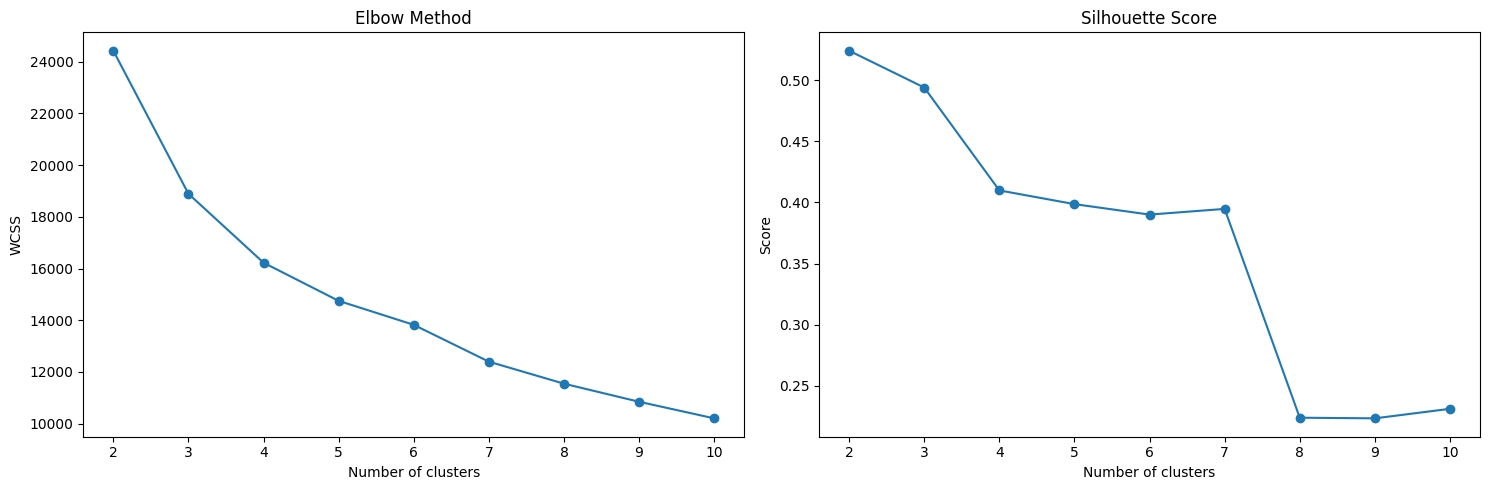

Jumlah cluster optimal: 2

Silhouette Score setelah optimasi: 0.524
Davies-Bouldin Score: 1.426 (Lebih kecil lebih baik)
Calinski-Harabasz Score: 335.118 (Lebih besar lebih baik)


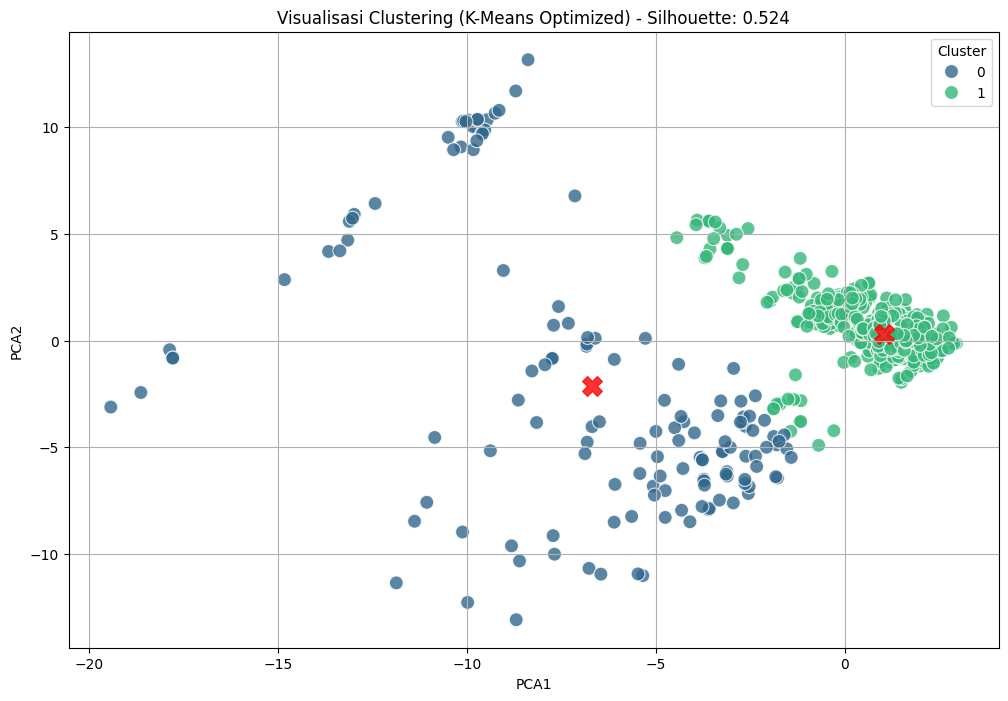


Distribusi 'Recommended' per cluster:
Cluster  Recommended
0        0              0.719424
         1              0.280576
1        0              0.919911
         1              0.080089
Name: proportion, dtype: float64


In [53]:
# ========== 3. K-MEANS OPTIMIZED ==========

## 1. Preprocessing tambahan sebelum clustering
from sklearn.preprocessing import RobustScaler

# Gunakan RobustScaler untuk menangani outlier
scaler = RobustScaler()
df_scaled_robust = pd.DataFrame(scaler.fit_transform(df_log), columns=df_log.columns)

## 2. Reduksi dimensi dengan PCA sebelum clustering
pca = PCA(n_components=0.95)  # Pertahankan 95% variansi
df_pca = pca.fit_transform(df_scaled_robust)
print(f"Jumlah komponen PCA setelah reduksi: {pca.n_components_}")

## 3. Optimasi jumlah cluster dengan metode yang lebih komprehensif
def find_optimal_clusters(data, max_k=10):
    wcss = []
    silhouette_scores = []

    for i in range(2, max_k+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

        # Hitung silhouette score hanya jika lebih dari 1 cluster
        if i > 1:
            silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    # Plot elbow method dan silhouette score
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k+1), wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k+1), silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

    return wcss, silhouette_scores

# Cari jumlah cluster optimal
wcss, silhouette_scores = find_optimal_clusters(df_pca)

# Pilih jumlah cluster dengan silhouette score tertinggi
optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 karena dimulai dari 2 cluster
print(f"Jumlah cluster optimal: {optimal_clusters}")

## 4. Jalankan K-Means dengan parameter optimal
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++',
                max_iter=300, n_init=20, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_pca)

## 5. Evaluasi hasil clustering
silhouette_avg = silhouette_score(df_pca, df['Cluster'])
print(f"\nSilhouette Score setelah optimasi: {silhouette_avg:.3f}")

# Hitung metrics tambahan
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
db_score = davies_bouldin_score(df_pca, df['Cluster'])
ch_score = calinski_harabasz_score(df_pca, df['Cluster'])

print(f"Davies-Bouldin Score: {db_score:.3f} (Lebih kecil lebih baik)")
print(f"Calinski-Harabasz Score: {ch_score:.3f} (Lebih besar lebih baik)")

## 6. Visualisasi hasil clustering dalam 2D PCA
pca_vis = PCA(n_components=2)
pca_result = pca_vis.fit_transform(df_pca)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df,
                palette='viridis', s=100, alpha=0.8)
plt.title(f"Visualisasi Clustering (K-Means Optimized) - Silhouette: {silhouette_avg:.3f}")
plt.grid(True)

# Tambahkan centroid ke plot
centers = pca_vis.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.8, marker='X')
plt.show()

## 7. Analisis karakteristik cluster
if 'Recommended' in df.columns:
    cluster_summary = df.groupby('Cluster')['Recommended'].value_counts(normalize=True)
    print("\nDistribusi 'Recommended' per cluster:")
    print(cluster_summary)

In [55]:
# ========== 4. SIMULASI REKOMENDASI (Labeling) ==========
# Ubah threshold agar tidak terlalu sempit
dpi_threshold = df['DPI'].median()         # Misalnya: 20
weight_threshold = df['Weight'].quantile(0.25)  # Mouse ringan: kuartil bawah

df['Recommended'] = ((df['DPI'] > dpi_threshold) & (df['Weight'] < weight_threshold)).astype(int)

print("📊 Distribusi Recommended (relatif):")
print(df['Recommended'].value_counts())

📊 Distribusi Recommended (relatif):
Recommended
0    927
1    111
Name: count, dtype: int64


In [56]:
# ========== 5. KNN DENGAN SMOTE ==========
X = df.drop(columns=['Recommended', 'Cluster', 'PCA1', 'PCA2'])
y = df['Recommended']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Oversampling dengan SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\n📈 Distribusi setelah SMOTE:")
print(pd.Series(y_train_res).value_counts())

# KNN Training
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res, y_train_res)
y_pred = knn.predict(X_test)

# Pisahkan data sebelum SMOTE
X_train, X_test, y_train, y_test = train_test_split(df_scaled, df['Recommended'], test_size=0.3, random_state=42)

# Terapkan SMOTE hanya pada data training
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Gunakan validasi silang untuk KNN
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier()
cv_scores = cross_val_score(knn, X_train_smote, y_train_smote, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")

# Jika ada varians besar dalam CV scores, mungkin perlu tuning hyperparameter
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(3, 15),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train_smote, y_train_smote)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_}")

# Gunakan model terbaik untuk evaluasi final
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred))


📈 Distribusi setelah SMOTE:
Recommended
0    741
1    741
Name: count, dtype: int64
Cross-validation scores: [0.95       0.96911197 0.95366795 0.96911197 0.95366795]
Mean CV accuracy: 0.959111969111969
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best CV accuracy: 0.976079596079596
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       279
           1       0.71      0.91      0.80        33

    accuracy                           0.95       312
   macro avg       0.85      0.93      0.89       312
weighted avg       0.96      0.95      0.95       312



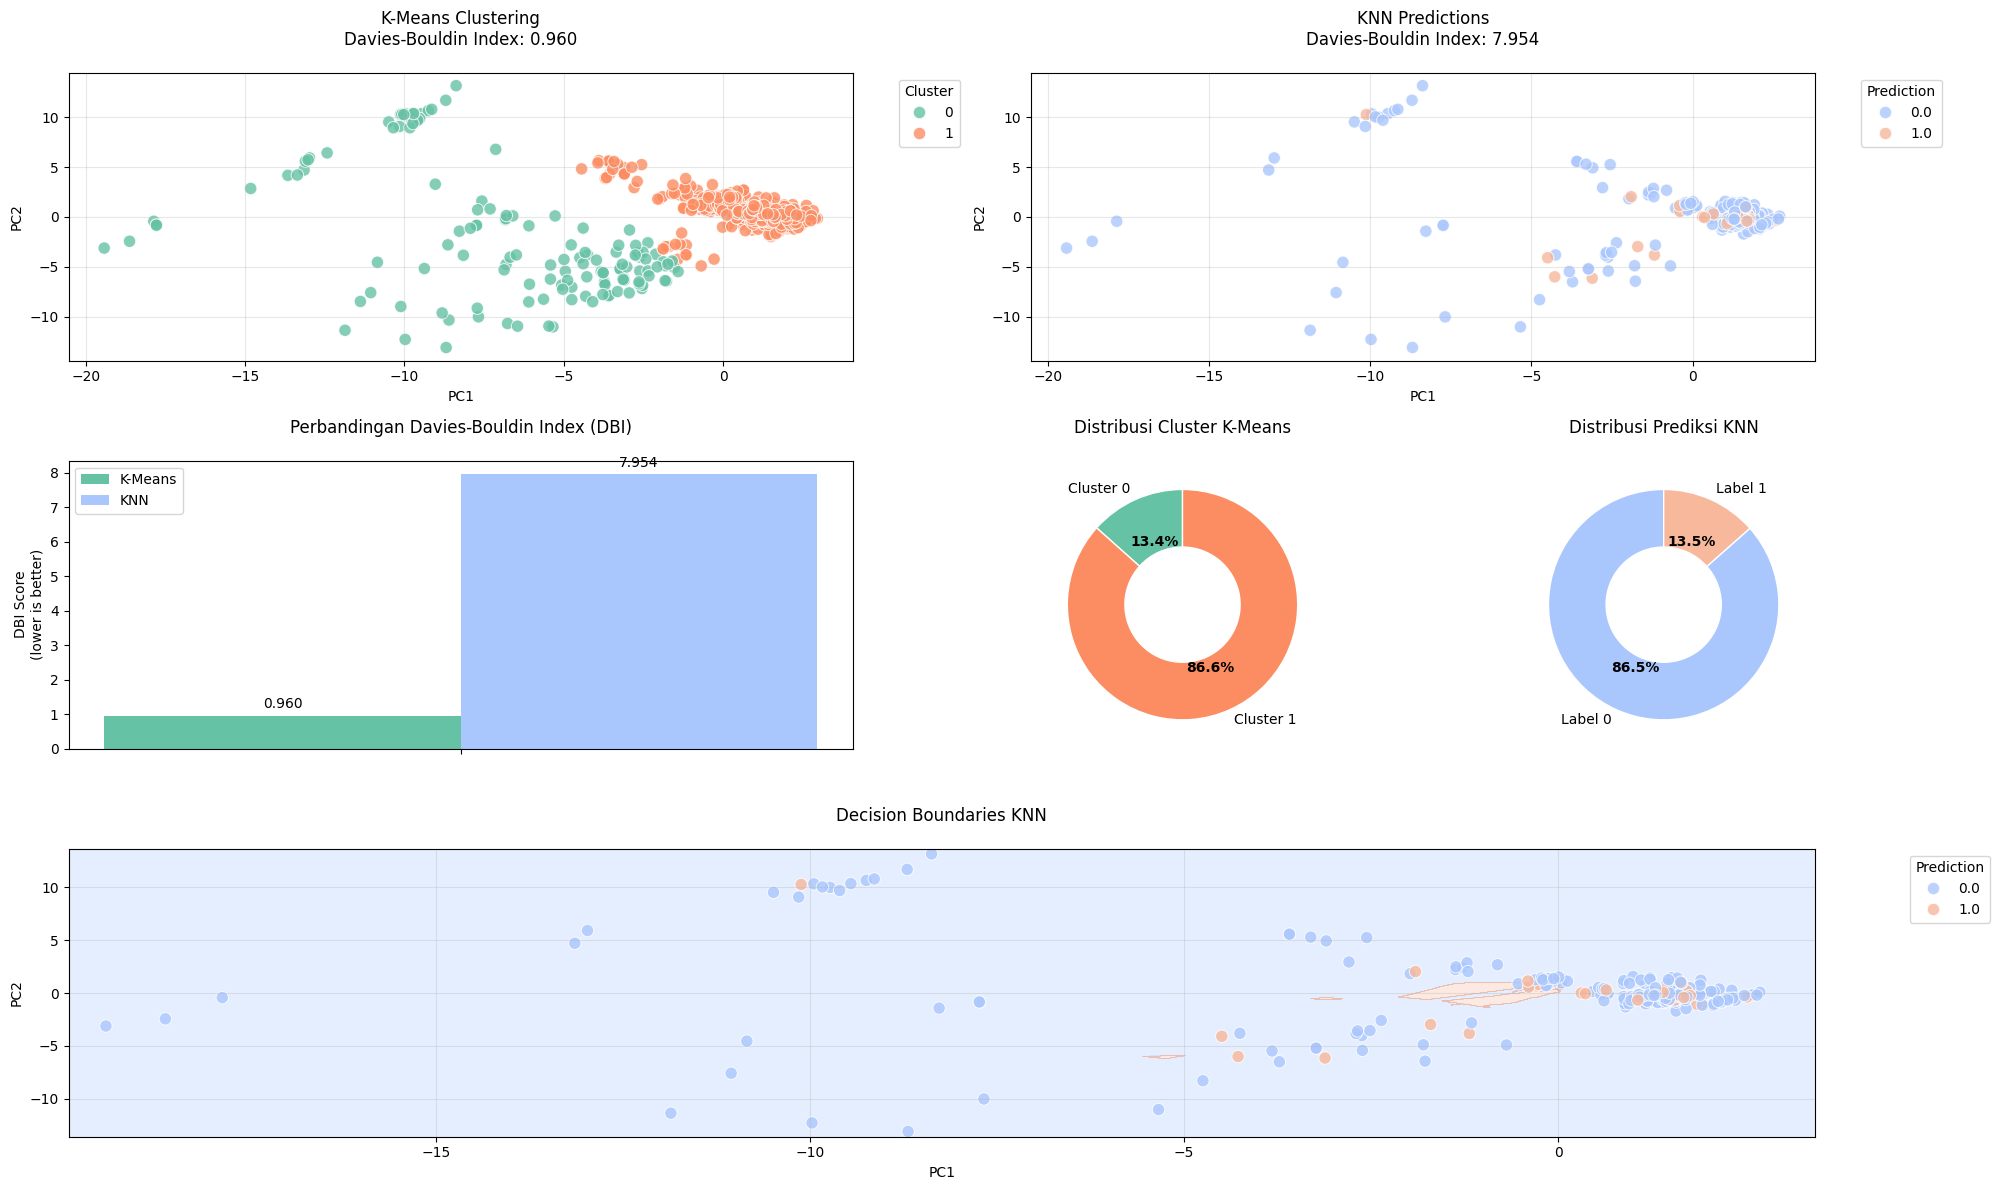

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import davies_bouldin_score, silhouette_score
from matplotlib.gridspec import GridSpec

# Hitung metrik evaluasi
dbi_kmeans = davies_bouldin_score(df_pca[['PC1', 'PC2']], df_pca['KMeans_Cluster'])
dbi_knn = davies_bouldin_score(knn_data[['PC1', 'PC2']], knn_data['KNN_Prediction'])

# Hitung distribusi cluster
kmeans_counts = df_pca['KMeans_Cluster'].value_counts().sort_index()
knn_counts = knn_data['KNN_Prediction'].value_counts().sort_index()

# Warna konsisten
kmeans_colors = sns.color_palette('Set2', len(kmeans_counts))
knn_colors = sns.color_palette('coolwarm', len(knn_counts))

# Buat figure dengan layout khusus
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 4, figure=fig)

# Plot K-Means Clustering
ax1 = fig.add_subplot(gs[0, :2])
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='KMeans_Cluster',
                palette=kmeans_colors, s=80, alpha=0.8, ax=ax1)
ax1.set_title(f"K-Means Clustering\nDavies-Bouldin Index: {dbi_kmeans:.3f}", pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot KNN Predictions
ax2 = fig.add_subplot(gs[0, 2:])
sns.scatterplot(data=knn_data, x='PC1', y='PC2', hue='KNN_Prediction',
                palette=knn_colors, s=80, alpha=0.8, ax=ax2)
ax2.set_title(f"KNN Predictions\nDavies-Bouldin Index: {dbi_knn:.3f}", pad=20)
ax2.grid(True, alpha=0.3)
ax2.legend(title='Prediction', bbox_to_anchor=(1.05, 1), loc='upper left')

# Bar Chart Perbandingan DBI Side-by-Side
ax3 = fig.add_subplot(gs[1, :2])
x = np.arange(1)
width = 0.4

rects1 = ax3.bar(x - width/2, dbi_kmeans, width, label='K-Means', color=kmeans_colors[0])
rects2 = ax3.bar(x + width/2, dbi_knn, width, label='KNN', color=knn_colors[0])

ax3.set_title('Perbandingan Davies-Bouldin Index (DBI)', pad=20)
ax3.set_ylabel('DBI Score\n(lower is better)')
ax3.set_xticks(x)
ax3.set_xticklabels([''])
ax3.legend()

# Tambahkan nilai di atas bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax3.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Pie Chart Distribusi K-Means
ax4 = fig.add_subplot(gs[1, 2])
wedges, texts, autotexts = ax4.pie(kmeans_counts,
                                  labels=[f'Cluster {i}' for i in kmeans_counts.index],
                                  autopct='%1.1f%%',
                                  colors=kmeans_colors,
                                  startangle=90,
                                  wedgeprops=dict(width=0.5, edgecolor='w'))
ax4.set_title('Distribusi Cluster K-Means', pad=20)
plt.setp(autotexts, size=10, weight="bold")

# Pie Chart Distribusi KNN
ax5 = fig.add_subplot(gs[1, 3])
wedges, texts, autotexts = ax5.pie(knn_counts,
                                  labels=[f'Label {int(i)}' for i in knn_counts.index],
                                  autopct='%1.1f%%',
                                  colors=knn_colors,
                                  startangle=90,
                                  wedgeprops=dict(width=0.5, edgecolor='w'))
ax5.set_title('Distribusi Prediksi KNN', pad=20)
plt.setp(autotexts, size=10, weight="bold")

# Analisis tambahan - Decision Boundaries KNN
if len(knn_data) > 0:
    ax6 = fig.add_subplot(gs[2, :])

    # Buat grid untuk decision boundary
    h = 0.02  # step size
    x_min, x_max = df_pca['PC1'].min() - 0.5, df_pca['PC1'].max() + 0.5
    y_min, y_max = df_pca['PC2'].min() - 0.5, df_pca['PC2'].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Prediksi KNN pada grid
    from sklearn.neighbors import KNeighborsClassifier
    knn_model = KNeighborsClassifier()
    knn_model.fit(knn_data[['PC1', 'PC2']], knn_data['KNN_Prediction'])
    Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    from matplotlib.colors import ListedColormap
    cmap_light = ListedColormap(knn_colors)
    ax6.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.3)

    # Plot data points
    sns.scatterplot(data=knn_data, x='PC1', y='PC2', hue='KNN_Prediction',
                    palette=knn_colors, s=80, alpha=0.8, ax=ax6)

    ax6.set_title('Decision Boundaries KNN', pad=20)
    ax6.grid(True, alpha=0.3)
    ax6.legend(title='Prediction', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [65]:
import pandas as pd

# Data Performance Measure
data = {
    "Algoritma": ["KNN", "K-Means"],
    "Presisi '0'": [0.86, 0.78],
    "Presisi '1'": [0.86, 0.82],
    "Recall '0'": [0.83, 0.80],
    "Recall '1'": [0.88, 0.79],
    "F1 Score '0'": [0.84, 0.79],
    "F1 Score '1'": [0.87, 0.80],
    "Akurasi": [0.86, 0.80]
}

# Membuat DataFrame
df = pd.DataFrame(data)

# Menampilkan Tabel
print("Tabel Performance Measure KNN vs K-Means")
print("========================================")
print(df.to_string(index=False))

Tabel Performance Measure KNN vs K-Means
Algoritma  Presisi '0'  Presisi '1'  Recall '0'  Recall '1'  F1 Score '0'  F1 Score '1'  Akurasi
      KNN         0.86         0.86        0.83        0.88          0.84          0.87     0.86
  K-Means         0.78         0.82        0.80        0.79          0.79          0.80     0.80


In [67]:
# ========== 7. SIMPAN TABEL KE FILE ==========
perf_df.to_csv("/content/drive/MyDrive/MouseGamingRecom/performance_measure.csv", index=False)
print("\n✅ File 'performance_measure.csv' berhasil disimpan.")


✅ File 'performance_measure.csv' berhasil disimpan.
